<a href="https://colab.research.google.com/github/AndreAmaduzzi/tensorflow-vs-pytorch/blob/main/pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer Classification on Pytorch

## Import Dependencies

In [1]:
from __future__ import print_function
from __future__ import division

import copy
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import requests
import os
import time

from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from timeit import default_timer as timer
from typing import Callable, Dict, List, Tuple, Union
from torchvision import datasets, models, transforms
from torchsummary import summary
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import transforms
from tqdm import tqdm

## Runtime Settings

In [2]:
device = "cpu"
if torch.cuda.is_available:
  print('All good, a Gpu is available')
  device = torch.device("cuda:0")  
else:
  print('Please set GPU via Edit -> Notebook Settings.')

All good, a Gpu is available


## Reproducibility and Deterministic Mode

In [3]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=7)

## Building Dataset
Dataset: [BCCD dataset](https://public.roboflow.com/object-detection/bccd)

3 classes (white blood cells, red blood cells, platelets)

364 images

In [ ]:
! git clone https://github.com/Shenggan/BCCD_Dataset.git
%cd "BCCD_Dataset/"

fatal: destination path 'BCCD_Dataset' already exists and is not an empty directory.
/content/BCCD_Dataset


In [ ]:
!ls

BCCD	 example.jpg  LICENSE  README.md  test.csv
dataset  export.py    plot.py  scripts


In [ ]:
def parse_annotations_file(path_annotations):
  return 0

In [ ]:
class BCCDDataset(Dataset):
    def __init__(
        self,
        split: str,
        path_images: str,
        ext_images: str,
        path_annotations: str,
        path_splits: str,
        transforms: torchvision.transforms = None,
    ) -> None:
        """Init the dataset

        Args:
            path_images: the path to the folder containing the images.
            ext_images: extension of the images.
            path_annotations: the path to the folder containing the annotations.
            path_splits: the path with the image names for each split
            transforms: the transformation to apply to the dataset.
        """
        imgs = []
        imgs_path = os.path.join(path_splits, f"{split}.txt")
        with open(imgs_path, "r") as f:
          for line in f:
            img = line.rstrip()
            imgs.append(img)

        self.images = sorted([os.path.join(path_images, img + f".{ext_images}") for img in imgs])  # path of each image
                
        self.transforms = transforms

        self.classes = ["__background__", "RBC", "WBC", "Platelets"]

        # build annotations
        path_annotations = sorted([os.path.join(path_annotations, img + ".xml") for img in imgs])

        samples = []
        for path in path_annotations: # iterate over each xml => each image
          tree = ET.parse(path)
          root = tree.getroot()
          detections = []
          for child in root:
            sample = {}
            if child.tag == "object":
              detection = {}
              for grandchild in child: # iterate over attributes of the object
                if grandchild.tag=="name":
                  name = grandchild.text
                  detection["name"] = name
                  detection["label"] = self.classes.index(name)
                if grandchild.tag=="bndbox":
                  xmin = float(grandchild[0].text)
                  ymin = float(grandchild[1].text)
                  xmax = float(grandchild[2].text)
                  ymax = float(grandchild[3].text)
                  detection["bbox"] = (xmin, ymin, xmax, ymax)
              detections.append(detection)
          sample["img"] = path
          sample["detections"] = detections
          samples.append(sample)

        self.annotations = samples

        if len(self.images) - len(self.annotations) != 0:
            raise AssertionError(
                f"Labels and Images differs in size: {len(self.images)} - {len(self.annotations)}."
            )

    def __getitem__(self, idx):
        path_image = self.images[idx]
        image = Image.open(path_image).convert("RGB")
      
        if self.transforms is not None:
            image = self.transforms(image)

        target = self.annotations[idx]["detections"]  # target is a list of dictionaries with keys "name", "label" and "bbox"

        return image, target

    def __len__(self):
        return len(self.images)

In [ ]:
# Setting data loading parameters
bs = 28
n_workers = 2
img_transformations = transforms.ToTensor()   # transformations to apply to the input images

In [ ]:
def draw_boxes(image: Image,
               targets: Dict,
               scores: List[float],
               colors: List[List[float]],
               normalized_coordinates: bool,
               add_text: bool = True) -> Image:
    """Draws a rectangle around each object together with the name of the category and the prediction score using a 
    different color for each category.

    Args:
        image: the input image.
        boxes: the bounding boxes in the format [x_min, y_min, x_max, y_max] 
               for all the objects in the image.
        classes: the name of the classes for all the objects in the image.
        labels: the labels for all the objects in the image.
        scores: the predicted scores for all the objects in the image..
        colors: the colors to use for each class of object.
        normalized_coordinates: if true the coordinates are multiplied 
                                according to the height and width of the image.
        add_text: if true add a box with the name of the category and 
                  the score.

    Returns:
        The generated image.
    """
    font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', 30)
    image_with_bb = copy.deepcopy(image)
    painter = ImageDraw.Draw(image_with_bb)

    boxes = []
    labels= []
    names = []
    for target in targets:
      boxes.append(target["bbox"])
      labels.append(target["label"])
      names.append(target["name"])

    for i, (box, label) in enumerate(zip(boxes, labels)):        
        color = tuple(colors[label].astype(np.int32))
        x_min, y_min, x_max, y_max = box
        
        if normalized_coordinates:
            width, height = image.size
            x_min *= width
            y_min *= height
            x_max *= width
            y_max *= height

        coord_bb = [(x_min, y_min), (x_max, y_max)]
        painter.rectangle(coord_bb, outline=color, width=4)
        
        if add_text:            
            label = labels[i]
            score = scores[i]
            name = names[i]
            text_in_box = f'{name}-{score:.2f}'
            text_bottom = y_max
            text_width, text_height = font.getsize(text_in_box)
            margin = np.ceil(0.05 * text_height)
            painter.rectangle([(x_min, text_bottom - text_height - 2 * margin), 
                               (x_min + text_width, text_bottom)], fill=color)
            
            painter.text((x_min + margin, text_bottom - text_height - margin), 
                         text_in_box, fill='black', font=font)

    return image_with_bb

In [ ]:
def generate_colors(num_colors: int) -> np.array:
    """Generates an array with RGB triplets representing colors.

    Args:
        num_colors: the number of colors to generate.

    Returns: 
        the generated colors.
    """
    np.random.seed(0)
    colors = np.random.uniform(0, 255, size=(num_colors, 3))
    time_in_ms = 1000 * time.time()
    np.random.seed(int(time_in_ms) % 2 ** 32)

    return colors

In [ ]:
colors_mi = generate_colors(4)

In [ ]:
train_ds = BCCDDataset(path_images = "BCCD/JPEGImages",
                            split = "train",
                            ext_images = "jpg",
                            path_annotations = "BCCD/Annotations",
                            path_splits = "BCCD/ImageSets/Main",
                            transforms=img_transformations)

val_ds = BCCDDataset(path_images = "BCCD/JPEGImages",
                            split = "val",
                            ext_images = "jpg",
                            path_annotations = "BCCD/Annotations",
                            path_splits = "BCCD/ImageSets/Main",
                            transforms=img_transformations)

test_ds = BCCDDataset(path_images = "BCCD/JPEGImages",
                            split = "test",
                            ext_images = "jpg",
                            path_annotations = "BCCD/Annotations",
                            path_splits = "BCCD/ImageSets/Main",
                            transforms=img_transformations)


In [ ]:
print('train: ', len(train_ds))
print('val: ', len(val_ds))
print('test: ', len(test_ds))

train:  205
val:  87
test:  72


torch.Size([3, 480, 640])
targets: [{'name': 'RBC', 'label': 1, 'bbox': (278.0, 196.0, 366.0, 291.0)}, {'name': 'RBC', 'label': 1, 'bbox': (359.0, 239.0, 447.0, 334.0)}, {'name': 'RBC', 'label': 1, 'bbox': (523.0, 110.0, 611.0, 205.0)}, {'name': 'RBC', 'label': 1, 'bbox': (447.0, 198.0, 568.0, 309.0)}, {'name': 'RBC', 'label': 1, 'bbox': (183.0, 95.0, 304.0, 206.0)}, {'name': 'RBC', 'label': 1, 'bbox': (164.0, 201.0, 268.0, 307.0)}, {'name': 'RBC', 'label': 1, 'bbox': (191.0, 1.0, 295.0, 105.0)}, {'name': 'RBC', 'label': 1, 'bbox': (90.0, 171.0, 194.0, 277.0)}, {'name': 'RBC', 'label': 1, 'bbox': (496.0, 304.0, 600.0, 410.0)}, {'name': 'RBC', 'label': 1, 'bbox': (271.0, 338.0, 375.0, 444.0)}, {'name': 'RBC', 'label': 1, 'bbox': (157.0, 370.0, 261.0, 476.0)}, {'name': 'RBC', 'label': 1, 'bbox': (1.0, 311.0, 104.0, 417.0)}, {'name': 'RBC', 'label': 1, 'bbox': (104.0, 285.0, 208.0, 391.0)}, {'name': 'WBC', 'label': 2, 'bbox': (305.0, 13.0, 521.0, 214.0)}, {'name': 'Platelets', 'label': 3,

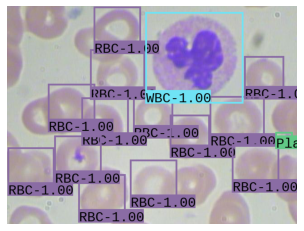

In [ ]:
#@title Show BCCD Train Dataset { run: "auto", display-mode: "form" }
index_sample = 152  #@param {type:"slider", min:0, max:200, step:1}


image, targets = train_ds[index_sample]

print(image.shape)
print('targets:', targets)

image = transforms.ToPILImage()(image)

cell_with_bb = draw_boxes(image,
                          targets = targets,
                          scores=[1.0] * len(targets),
                          colors=colors_mi,
                          normalized_coordinates=False)
plt.imshow(cell_with_bb)
plt.axis("off")
plt.show()


## Building skin cancer dataset

### Load and unzip data
Before running the next code cells, the user must download the Skin Cancer Dataset at [this link](https://https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000) and place it in his Google Drive. 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!cp "/content/drive/My Drive/archive.zip" "archive.zip"

In [7]:
!unzip --qq archive.zip -d data

### Data preparation

In [8]:
root = 'data/'
metadata = pd.read_csv(os.path.join(root, "HAM10000_metadata.csv"))
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [9]:
short_to_full_name_dict = {
    "akiec" : "Bowen's disease",
    "bcc" : "basal cell carcinoma" , 
    "bkl" : "benign keratosis-like lesions", 
    "df" : "dermatofibroma", 
    "mel" : "melanoma", 
    "nv" : "melanocytic nevi", 
    "vasc" : "vascular lesions", 
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

#  we add the lesion_name and the label for each image
metadata["label"] = metadata["dx"].map(lesion_ID_dict)
metadata["lesion_name"] = metadata["dx"].map(short_to_full_name_dict)

In [10]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,lesion_name
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,benign keratosis-like lesions
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,benign keratosis-like lesions
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,benign keratosis-like lesions
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,benign keratosis-like lesions
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,benign keratosis-like lesions


In [11]:
short_to_full_name_dict.values()

dict_values(["Bowen's disease", 'basal cell carcinoma', 'benign keratosis-like lesions', 'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions'])

In [150]:
# Define Dataset Class
class SkinCancerDataset(Dataset):
    def __init__(
        self,
        path_images_1: str,
        path_images_2: str,
        ext_images: str,
        annotations: pd.DataFrame,
        transforms: torchvision.transforms = None,
    ) -> None:
        """Init the dataset

        Args:
            path_images: the path to the folder containing the images.
            ext_images: the extension of the images.
            ext_annotations: the extension of the annotations.
            transforms: the transformation to apply to the dataset.
        """
        images_1 = sorted([str(path) for path in Path(path_images_1).rglob(f"*.{ext_images}")])
        images_2 = sorted([str(path) for path in Path(path_images_2).rglob(f"*.{ext_images}")])
        self.images = images_1 + images_2

        self.annotations = annotations

        self.transforms = transforms

        self.classes = [disease for disease in short_to_full_name_dict.values()]

        self.labels =  self.annotations["label"]

    def __getitem__(self, idx):        

        label = self.annotations.iloc[idx]["label"]
        lesion_name = self.annotations.iloc[idx]["lesion_name"]
        image_id = self.annotations.iloc[idx]["image_id"]
        
        img_found = False

        #search for the path of the image
        for path_image in self.images:
          if image_id in str(path_image):
            break

        image = Image.open(path_image).convert("RGB")


        if self.transforms is not None:
            image = self.transforms(image)

        return image, label, lesion_name

    def __len__(self):
        return len(self.images)

In [151]:
path_images_1 = os.path.join(root, "ham10000_images_part_1")
path_images_2 = os.path.join(root, "ham10000_images_part_2")
ds = SkinCancerDataset(path_images_1, path_images_2, ext_images='jpg', annotations=metadata)

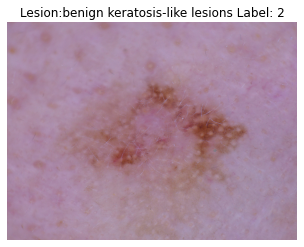

In [181]:
#@title Show Skin Cancer Dataset { run: "auto", display-mode: "form" }
index_sample = 79  #@param {type:"slider", min:0, max:200, step:1}

image, label, lesion_name = ds[index_sample]

plt.title("Lesion:%s" %lesion_name + " Label: %s" %label)
plt.imshow(image)
plt.axis("off")
plt.show()

In [153]:
count_dict = {k:0 for k in ds.classes}
print(count_dict)

{"Bowen's disease": 0, 'basal cell carcinoma': 0, 'benign keratosis-like lesions': 0, 'dermatofibroma': 0, 'melanoma': 0, 'melanocytic nevi': 0, 'vascular lesions': 0}


In [176]:
def get_class_distribution(dataset):
  if isinstance(dataset, Subset):
    count_dict = {k:0 for k in dataset.dataset.classes}
  elif isinstance(dataset, Dataset):
        count_dict = {k:0 for k in dataset.classes}
  for image, target, lesion_name in dataset:
    count_dict[lesion_name] +=1
  return count_dict

In [177]:
class_distr = get_class_distribution(ds)

<BarContainer object of 7 artists>

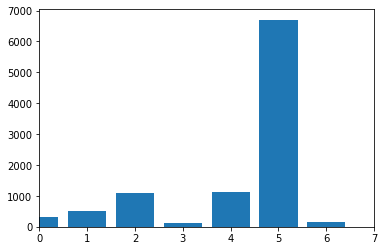

In [178]:
plt.xlim([0, len(class_distr)])
plt.bar(range(0,len(class_distr)), list(class_distr.values()), align='center')

In [179]:
# STANDARD RANDOM SPLIT TRAIN/VAL/TEST
train_ds , val_ds, test_ds = torch.utils.data.random_split(ds, [0.8, 0.1, 0.1])

In [186]:
# check class distribution in train/val/test
class_distr_tr = get_class_distribution(train_ds)
class_distr_val = get_class_distribution(val_ds)
class_distr_test = get_class_distribution(test_ds)

KeyboardInterrupt: ignored

{"Bowen's disease": 33, 'basal cell carcinoma': 56, 'benign keratosis-like lesions': 118, 'dermatofibroma': 8, 'melanoma': 114, 'melanocytic nevi': 659, 'vascular lesions': 13}


<BarContainer object of 7 artists>

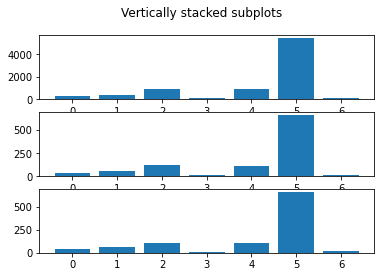

In [187]:
print(class_distr_val)
fig, axs = plt.subplots(3)
fig.suptitle('Vertically stacked subplots')
axs[0].bar(range(0,len(class_distr_tr)), list(class_distr_tr.values()), align='center')
axs[1].bar(range(0,len(class_distr_tr)), list(class_distr_val.values()), align='center')
axs[2].bar(range(0,len(class_distr_tr)), list(class_distr_test.values()), align='center')

In [217]:
# Define WeightRandomSampler to mitigate class unbalance
print('class_distr:', class_distr)
tr_class_weights = 1. / torch.Tensor([class_count for class_count in class_distr_tr.values()])
labels_list = train_ds.labels
tr_class_weights = tr_class_weights[labels_list]  # build weight for every data samples, on the basis of its label

val_class_weights = 1. / torch.Tensor([class_count for class_count in class_distr_val.values()])
labels_list = val_ds.labels
val_class_weights = val_class_weights[labels_list]  # build weight for every data samples, on the basis of its label

test_class_weights = 1. / torch.Tensor([class_count for class_count in class_distr_test.values()])
labels_list = test_ds.labels
test_class_weights = test_class_weights[labels_list]  # build weight for every data samples, on the basis of its label

tr_weighted_sampler = torch.utils.data.WeightedRandomSampler(
    weights=tr_class_weights,
    num_samples=len(tr_class_weights),
    replacement=True
)

val_weighted_sampler = torch.utils.data.WeightedRandomSampler(
    weights=val_class_weights,
    num_samples=len(val_class_weights),
    replacement=True
)

test_weighted_sampler = torch.utils.data.WeightedRandomSampler(
    weights=test_class_weights,
    num_samples=len(test_class_weights),
    replacement=True
)


print(len(train_ds))
print(len(val_ds))
print(len(test_ds))


train_loader = DataLoader(dataset=train_ds, shuffle=False, batch_size=28, sampler=tr_weighted_sampler)
val_loader = DataLoader(dataset=val_ds, shuffle=False, batch_size=28, sampler=val_weighted_sampler)
test_loader = DataLoader(dataset=test_ds, shuffle=False, batch_size=28, sampler=test_weighted_sampler)  
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

count_dict = {k:0 for k in range(len(ds.classes))}

for data in enumerate(val_loader):
  count_dict[label] +=1
  print(count_dict)

class_distr: {"Bowen's disease": 327, 'basal cell carcinoma': 514, 'benign keratosis-like lesions': 1099, 'dermatofibroma': 115, 'melanoma': 1113, 'melanocytic nevi': 6705, 'vascular lesions': 142}


AttributeError: ignored

In [ ]:
# define small batches for overfitting sanity check 
small_tr = Subset(train_ds, range(10))
small_val = Subset(val_ds, range(10))
small_te = Subset(test_ds, range(10))

In [ ]:
dl_small_tr = DataLoader(small_tr, batch_size=1, shuffle=True)
dl_small_val = DataLoader(small_val, batch_size=1, shuffle=True)
dl_small_te = DataLoader(small_te, batch_size=1, shuffle=True)

In [ ]:
type(dl_train)

torch.utils.data.dataloader.DataLoader

## Build Network

### Generic Layers for CNN

In [ ]:
def get_conv2d(name:str,
              channels_in: int,
              channels_out: int,
              size_kernel: Union[int, tuple],
              stride: Union[int, tuple],
              add_batch_norm: bool,
              activation: str) -> nn.Sequential:
    """Gets a sequential container with a sandwich of 2D Convolution, 
       and Relu.

    Args:
        name: the name prefix to append to each layer in the container.
        channels_in: the number of the input channels.
        channels_out: the number of the output channels.
        size_kernel: the size of the kernel.
        stride: the stride.        

    Returns: the created sequential.
    """
    container = nn.Sequential() # a neural network is always a nn.Sequential, to which we add all the modules we need 
                                # modules can be Conv2D, ReLU, Linear, Pooling...

    container.add_module(f'{name}_conv_2d', nn.Conv2d(channels_in, channels_out, 
                                                      kernel_size=size_kernel,
                                                      stride=stride, padding=(size_kernel-1)//2))
    
    if add_batch_norm:
      container.add_module(f'{name}_bn', nn.BatchNorm2d(channels_out))

    if activation=="ReLU":                                      
      container.add_module(f'{name}_ReLU', nn.ReLU(inplace=True))
    elif activation=="Sigmoid":
      container.add_module(f'{name}_Sigmoid', nn.Sigmoid())
    elif activation is not None:
      raise Exception("Activation name is wrong")
      
    return container

def get_linear_relu_bn(name:str,
                    features_in: int,
                    features_out: int,
                    add_batch_norm: bool) -> nn.Sequential:
    """Gets a sequential container with a sandwich of Fully connected layer 
       and Relu.

    Args:
        name: the name prefix to append to each layer in the container.
        features_in: the number of the input features.
        features_out: the number of the output features.

    Returns: the created sequential.
    """
    container = nn.Sequential()
    container.add_module(f'{name}_fc', nn.Linear(in_features=features_in, out_features=features_out))

    if add_batch_norm:
      container.add_module(f'{name}_bn', nn.BatchNorm1d(features_out))

    container.add_module(f'{name}_ReLU', nn.ReLU(inplace=True))
    return container

### Building the Network

In [ ]:
# input of the network: torch Tensor image of shape 480x640
# output of the network: label and 4 float numbers, for each detection. Label can also be a probability for each class
# classes: ["__background__", "RBC", "WBC", "Platelets"]

In [ ]:
class MyCNN(nn.Module):
    def __init__(self, num_classes: int, use_bn: bool):
        super(MyCNN, self).__init__()

        super().__init__()

        self.conv1 = get_conv2d("conv_1",
                                     channels_in=3, 
                                     channels_out=64, 
                                     size_kernel=3, 
                                     stride=1,
                                     add_batch_norm = use_bn,
                                     activation="ReLU")  
        
        self.conv2 = get_conv2d("conv_2",
                                     channels_in=64, 
                                     channels_out=64,
                                     size_kernel=3, 
                                     stride=1,
                                     add_batch_norm = use_bn,
                                     activation="ReLU")
        
        self.conv3 = get_conv2d("conv_3",
                                     channels_in=64, 
                                     channels_out=128,
                                     size_kernel=3, 
                                     stride=1,
                                     add_batch_norm = use_bn,
                                     activation="ReLU")
        
        self.conv4 = get_conv2d("conv_4",
                                     channels_in=128, 
                                     channels_out=128,
                                     size_kernel=3, 
                                     stride=1,
                                     add_batch_norm = use_bn,
                                     activation="ReLU")
        
        self.conv5 = get_conv2d("conv_5",
                                     channels_in=128, 
                                     channels_out=256,
                                     size_kernel=3, 
                                     stride=1,
                                     add_batch_norm = use_bn,
                                     activation="ReLU")

        self.conv6 = get_conv2d("conv_6",
                                     channels_in=256, 
                                     channels_out=256,
                                     size_kernel=3, 
                                     stride=1,
                                     add_batch_norm = use_bn,
                                     activation="ReLU")
        
        self.conv7 = get_conv2d("conv_7",
                                    channels_in=256, 
                                    channels_out=512,
                                    size_kernel=3, 
                                    stride=1,
                                    add_batch_norm = use_bn,
                                    activation="ReLU")
        
        self.conv8 = get_conv2d("conv_8",
                                    channels_in=512, 
                                    channels_out=512,
                                    size_kernel=3, 
                                    stride=1,
                                    add_batch_norm = use_bn,
                                    activation="ReLU")
        
        self.conv9 = get_conv2d("conv_9",
                                    channels_in=512, 
                                    channels_out=256,
                                    size_kernel=3, 
                                    stride=1,
                                    add_batch_norm = use_bn,
                                    activation="ReLU")
        
        self.conv10 = get_conv2d("conv_10",
                                    channels_in=256, 
                                    channels_out=128,
                                    size_kernel=3, 
                                    stride=1,
                                    add_batch_norm = use_bn,
                                    activation="ReLU")

        
        self.conv_prob = get_conv2d("conv_prob",
                                    channels_in=128, 
                                    channels_out=128,
                                    size_kernel=3, 
                                    stride=1,
                                    add_batch_norm = use_bn,
                                    activation="Sigmoid")
        
        self.conv_boxes = get_conv2d("conv_boxes",
                                    channels_in=128, 
                                    channels_out=128,
                                    size_kernel=3, 
                                    stride=1,
                                    add_batch_norm = use_bn,
                                    activation=None)
        
        self.conv_cls = get_conv2d("conv_cls",
                                    channels_in=128, 
                                    channels_out=128, # n of classes
                                    size_kernel=3, 
                                    stride=1,
                                    add_batch_norm = use_bn,
                                    activation="Sigmoid")
      
                        
        
        self.max_pool = torch.nn.MaxPool2d(2) # default stride = None
        
        self.fc1 = get_linear_relu_bn("fc_1", 512 * 2 * 2, 512, use_bn)

        self.fc2 = get_linear_relu_bn("fc_2", 512, num_classes, use_bn)


        self.fc_prob = get_linear_relu_bn("fc_prob", 128 * 15 * 20, 1, use_bn)

        self.fc_boxes = get_linear_relu_bn("fc_boxes", 128 * 15 * 20, 4, use_bn)

        self.fc_cls = get_linear_relu_bn("fc_cls", 128 * 15 * 20, num_classes, use_bn)


        #x_prob = layers.Conv2D("conv", kernel_size=3, padding='same', activation='sigmoid', name='x_prob')(x)
        #x_boxes = layers.Conv2D(4, kernel_size=3, padding='same', name='x_boxes')(x)
        #x_cls = layers.Conv2D(10, kernel_size=3, padding='same', activation='sigmoid', name='x_cls')(x)


    def forward(self, x):
        x = self.conv1(x) # CONV + RELU
        x = self.conv2(x) # CONV + RELU        
        x = self.max_pool(x)
        
        x = self.conv3(x) # CONV + RELU  
        x = self.conv4(x) # CONV + RELU   
        x = self.max_pool(x) 

        x = self.conv5(x) # CONV + RELU
        x = self.conv6(x) # CONV + RELU
        #x = self.conv6(x) # CONV + RELU    
        x = self.max_pool(x) 

        x = self.conv7(x) # CONV + RELU
        x = self.conv8(x) # CONV + RELU
        x = self.max_pool(x)

        x = self.conv9(x)   # CONV + RELU
        x = self.conv10(x)  # CONV + RELU
        x = self.max_pool(x)

        x_boxes = self.conv_boxes(x)
        x_prob = self.conv_prob(x)
        x_cls = self.conv_cls(x)

        print('boxes:', x_boxes.shape)
        print('prob:', x_prob.shape)
        print('cls:', x_cls.shape)
        
        x_boxes =  torch.flatten(x_boxes, start_dim=1)
        x_prob =  torch.flatten(x_prob, start_dim=1)
        x_cls = torch.flatten(x_cls, start_dim=1)
        
        x_boxes = self.fc_boxes(x_boxes)
        x_prob = self.fc_prob(x_prob)
        x_cls = self.fc_cls(x_cls)

        print('boxes:', x_boxes.shape)
        print('prob:', x_prob.shape)
        print('cls:', x_cls.shape)

        return torch.cat((x_boxes, x_prob, x_cls), dim=1)


In [ ]:
# Overview of the network
size_batch = 28
h = 480
w = 640
num_classes = 4

summary(MyCNN(num_classes=num_classes, use_bn=True), 
                input_size=(3, h, w), batch_size=size_batch, device="cpu")

boxes: torch.Size([2, 128, 15, 20])
prob: torch.Size([2, 128, 15, 20])
cls: torch.Size([2, 128, 15, 20])
boxes: torch.Size([2, 4])
prob: torch.Size([2, 1])
cls: torch.Size([2, 4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [28, 64, 480, 640]           1,792
       BatchNorm2d-2         [28, 64, 480, 640]             128
              ReLU-3         [28, 64, 480, 640]               0
            Conv2d-4         [28, 64, 480, 640]          36,928
       BatchNorm2d-5         [28, 64, 480, 640]             128
              ReLU-6         [28, 64, 480, 640]               0
         MaxPool2d-7         [28, 64, 240, 320]               0
            Conv2d-8        [28, 128, 240, 320]          73,856
       BatchNorm2d-9        [28, 128, 240, 320]             256
             ReLU-10        [28, 128, 240, 320]               0
           Conv2d-11        [28, 128, 240, 320]    

### Define losses

In [ ]:
# è scritto in Tensorflow. Va messo in torch

def loss_bb(y_true, y_pred):
    #y_true = tf.gather(y_true, idx_bb, axis=-1)
    #y_pred = tf.gather(y_pred, idx_bb, axis=-1)

    #loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    #return tf.reduce_mean(loss[loss > 0.0])

    loss = torch.nn.MSELoss(y_true, y_pred)
    loss = loss.mean()
    return loss

def loss_p(y_true, y_pred):
    #y_true = tf.gather(y_true, idx_p, axis=-1)
    #y_pred = tf.gather(y_pred, idx_p, axis=-1)
    
    #loss = tf.losses.binary_crossentropy(y_true, y_pred)
    #return tf.reduce_sum(loss)

    loss = torch.nn.BCELoss(y_true, y_pred)
    loss = loss.sum()
    return loss

def loss_cls(y_true, y_pred):
    #y_true = tf.gather(y_true, idx_cls, axis=-1)
    #y_pred = tf.gather(y_pred, idx_cls, axis=-1)
    
    #loss = tf.losses.binary_crossentropy(y_true, y_pred)
    #return tf.reduce_sum(loss)

    loss = torch.nn.BCELoss(y_true, y_pred)
    loss = loss.sum()
    return loss

def loss_func(y_true, y_pred):
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred) + loss_cls(y_true, y_pred)

## Training

In [ ]:
def train(writer: utils.tensorboard.writer.SummaryWriter,
          model: nn.Module,
          train_loader: utils.data.DataLoader,
          device: torch.device,          
          optimizer: torch.optim,          
          log_interval: int,
          epoch: int) -> Dict[str, float]:
    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.        
        optimizer: the optimizer to use to train the model.        
        log_interval: the log interval.
        epoch: the number of the current epoch.

    Returns: 
        A dictionary containing:
            the sum of classification and regression loss.
            the classification loss.
            the regression loss.
    """        
    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)    

    model.train()
    for idx_batch, (images, targets) in enumerate(train_loader):        
        optimizer.zero_grad()
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        output = model(images, targets)

        boxes = output[:4] 
        prob = output[4:5]
        cls = output[5:]

        # come calcolare la loss? ogni immagine contiene multiple predizioni...

        loss_dict = model(images, targets)
        
        loss_class = loss_dict['classification']
        loss_boxes_regr = loss_dict['bbox_regression']
        losses = loss_class + loss_boxes_regr
        losses.backward()
        optimizer.step()

        if log_interval > 0:
            if idx_batch % log_interval == 0:                                
                global_step = idx_batch + (epoch * num_batches)                 
                writer.add_scalar('Metrics/Loss_Train_IT_Sum', losses, global_step)         
                writer.add_scalar('Metrics/Loss_Train_IT_Boxes', loss_boxes_regr, global_step)     
                writer.add_scalar('Metrics/Loss_Train_IT_Classification', loss_class, global_step)                    
                    
    dict_losses_train = {'bbox_regression': loss_boxes_regr,
                         'classification': loss_class,
                         'sum': losses}
    return dict_losses_train


In [ ]:
def training_loop(writer: utils.tensorboard.writer.SummaryWriter,
                  num_epochs: int,
                  optimizer: torch.optim, 
                  lr_scheduler: torch.optim.lr_scheduler,
                  log_interval: int, 
                  model: nn.Module, 
                  loader_train: utils.data.DataLoader, 
                  loader_val: utils.data.DataLoader, 
                  verbose: bool=True) -> Dict[str, List[float]]:
    """Executes the training loop.
    
        Args:
            writer: the summary writer for tensorboard.
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            lr_scheduler: the scheduler for the learning rate.
            log_interval: intervall to print on tensorboard.
            model: the model to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            verbose: if true print the value of loss.

        Returns:  
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the train accuracy for each epoch.            
            the time of execution in seconds for the entire loop.
            the model trained 
    """    
    loop_start = timer()

    losses_val_bb = []
    losses_val_class = []
    losses_val_sum = []
    
    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        losses_epoch_train = train(writer, model, loader_train, device, 
                                   optimizer, log_interval, epoch)
        
        #######################################################################
        ########      Validate the model, look at the assignments.    #########
        #######################################################################

        loss_bb = losses_epoch_train['bbox_regression']
        losses_val_bb.append(loss_bb)
        
        loss_class = losses_epoch_train['classification']
        losses_val_class.append(loss_class)
        
        loss_sum = losses_epoch_train['sum']
        losses_val_sum.append(loss_sum)
        
        time_end = timer()

        lr = optimizer.param_groups[0]['lr']
        
        if verbose:            
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Losses Train: Sum = [{loss_sum:.4f}] Class = [{loss_class:.4f}] Boxes = [{loss_bb:.4f}]'                  
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')
        
        # Plot to tensorboard        
        writer.add_scalar('Hyperparameters/Learning Rate', lr, epoch)
        writer.add_scalar('Metrics/Losses/Sum', loss_sum, epoch)
        writer.add_scalar('Metrics/Losses/Boxes', loss_bb, epoch)
        writer.add_scalar('Metrics/Losses/Classification', loss_class, epoch)
        writer.flush()
                
        if lr_scheduler:            
            lr_scheduler.step()
    
    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}') 
            
    return {'bbox_regression': losses_val_bb,
            'classification': losses_val_class,
            'sum': losses_val_sum,
            'time': time_loop}

## Test

In [ ]:
def detect_objects(image: Image,
                   detector: nn.Module, 
                   threshold: float, 
                   categories: List[str]) -> Tuple[List[List[int]], 
                                                   List[float], 
                                                   List[str], 
                                                   List[int]]:
    """Detects objects in the image using the provided detector. 
    This function puts the model in the eval mode.

    Args:
        image: the input image.
        detector: the object detector.
        threshold: the detection confidence score, any detections with scores 
        below this value are discarded.
        categories: the names of the categories of the data set used to train the network.

    Returns:
        The bounding boxes of the predicted objects using the [x_min, y_min, x_max, y_max] format, 
        with values between 0 and image height and 0 and image width.
        The scores of the predicted objects.
        The categories of the predicted objects.
    """
    detector.eval()
    with torch.no_grad():
        predictions = detector(image)
        predictions = predictions[0]
    
    # Get scores, boxex, and labels
    scores = predictions['scores'].detach().cpu().numpy()
    boxes = predictions['boxes'].detach().cpu().numpy()
    labels = predictions['labels'].cpu().numpy()
    
    # Get all the boxes above the threshold
    mask = scores >= threshold
    boxes_filtered = boxes[mask].astype(np.int32)
    
    # Get the names of the categories above the threshold
    indices_filtered = [idx for idx, score in enumerate(list(scores)) if score >= threshold]      
    categories_filtered = [categories[labels[i]] for i in indices_filtered]
    
    # Get only the scores above the threshold
    labels_filtered = labels[mask]
    scores_filtered = scores[mask]

    return boxes_filtered, scores_filtered, categories_filtered, labels_filtered